# <center>Single View Geometry</center>
## <center> Obtaining 3D affine measurements from a single view of a scene[1]: calculating the height of a person given a reference height of an object</center>

### Import the necessary libraries.

In [1]:
orange = (255,155,0)
yellow = (255,255,0)
red = (255,0,0)
blue = (0,0,255)
green = (0,255,0)
purple = (255,0,255)
door = 202 #this is the height (in cm) of the door that we know from the real world

In [2]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from visio_per_computador.common import geometry
plt.rcParams["figure.figsize"] = (20,10)
#%matplotlib notebook 

### Given image
From the interactive image, we obtain the desired points. The reference object is the door in the left part of the image which we are going to draw a yellow line. The goal is to obtain the height of the person in the image (orange line).

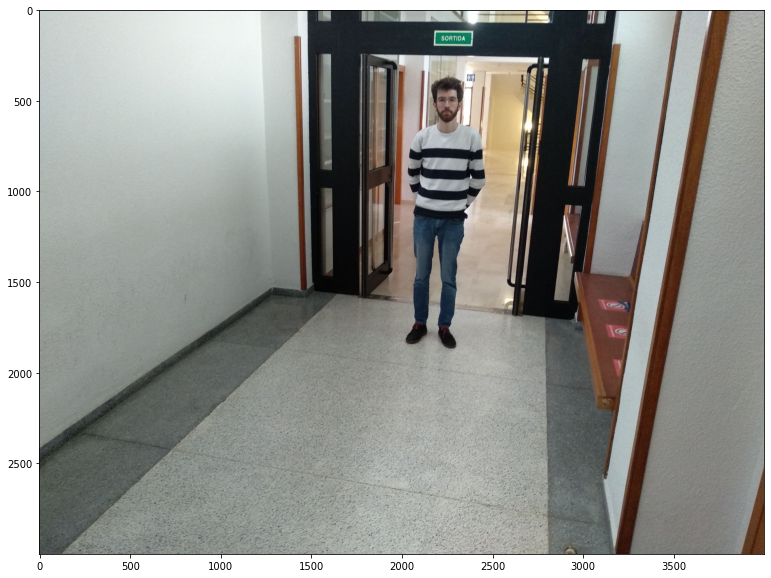

In [3]:
im = cv2.imread("../../in/metronomy/passadis.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

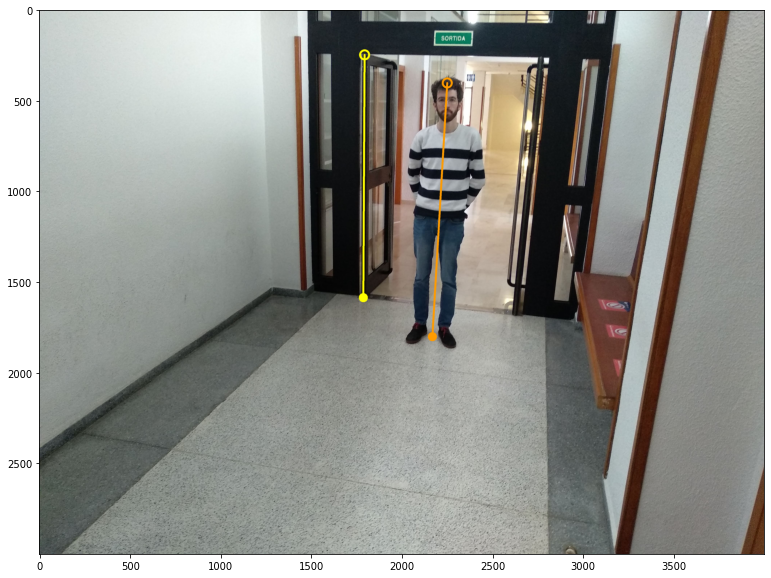

In [4]:
b_door_o, t_door_o = (1789,1586),(1796,247) #bottom and top points of the door
b_M_o, t_M_o = (2170,1801),(2252,402) #bottom and top points of the person M

#We draw the segment representing both heights in the image
im = geometry.my_segment(im,b_M_o,t_M_o,orange,10,25)
im = geometry.my_segment(im,b_door_o,t_door_o,yellow,10,25)
plt.imshow(im)
plt.show()

### We are going to use the following equation in order to obtain the desired height

\begin{align}
\alpha Z_i = - \frac{||b_i \times t_i||}{(l·b_i)||v_z \times t_i||} \;\;\; i = r,x
\end{align}

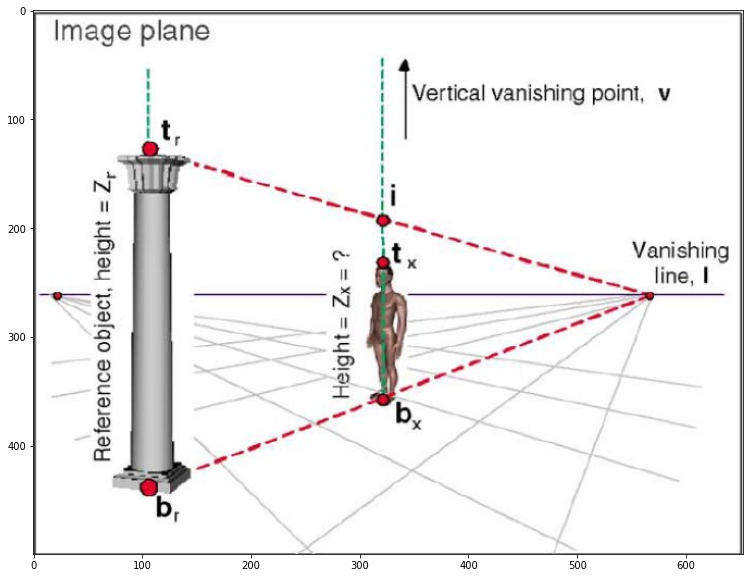

In [5]:
zDiagram = cv2.imread("../../in/metronomy/zDiagram.jpg")
zDiagram = cv2.cvtColor(zDiagram, cv2.COLOR_BGR2RGB)
plt.imshow(zDiagram)
plt.show()

We already have the reference and the desired height, with which we can obtain the vertical vanishing point $v_z$ . But now we need the vanishing line of the reference plane in which rests the reference object. In order to obtain it we are going to take 2 pairs of parallel lines from the image. The intersection of each pair is a point of the vanishing line. With those points we obtain the line.

## Vanishing line

We know that the floor tiles are parallelograms, so we can take the corners of the floor tile in front of the person to get our two pairs of parallel lines. We will be selecting the points as follows:  

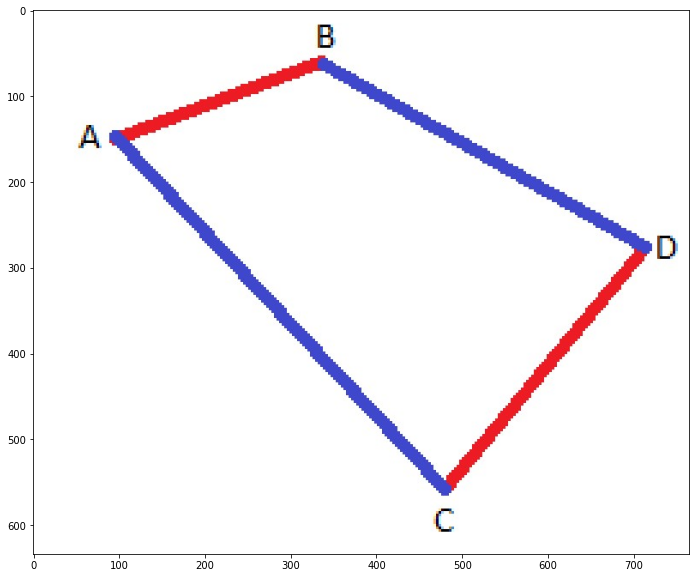

In [6]:
parallelogram = cv2.imread("../../in/metronomy/parallelogram2.jpg")
parallelogram = cv2.cvtColor(parallelogram, cv2.COLOR_BGR2RGB)
plt.imshow(parallelogram)
plt.show()

In [7]:
pA, pB = (733, 2421), (1327, 1865)
pC, pD = (2810, 2790), (2799, 2062)

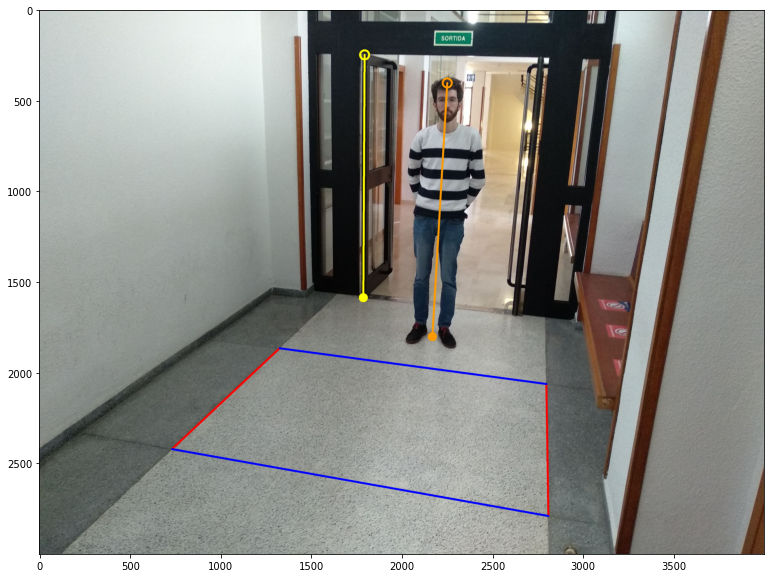

In [8]:
im = cv2.line(im,pA,pB,red,10)
im = cv2.line(im,pC,pD,red,10)

im = cv2.line(im,pA,pC,blue,10)
im = cv2.line(im,pB,pD,blue,10)

plt.imshow(im)
plt.show()

In order to do the calculations we need to convert the coordinates of the image to homogenous coordinates.

In [9]:
pA_h = geometry.convert(pA,im,geometry.ORG_2_HMG)
pB_h = geometry.convert(pB,im,geometry.ORG_2_HMG)
pC_h = geometry.convert(pC,im,geometry.ORG_2_HMG)
pD_h = geometry.convert(pD,im,geometry.ORG_2_HMG)

Once we have the points in homogenous coordinates, we obtain the parallel lines as the cross product of their respective points and the vanishing point as the cross product of the parallel lines.

In [10]:
vp1s_h = np.cross(pA_h,pB_h)
vp2s_h = np.cross(pC_h,pD_h)

vp3s_h = np.cross(pA_h,pC_h)
vp4s_h = np.cross(pB_h,pD_h)

In [11]:
vp1_h = np.cross(vp1s_h,vp2s_h)
vp2_h = np.cross(vp3s_h,vp4s_h)

Now, if we want to draw the vanishing points and vanishing line we need to converte those points to image coordinates.

In [12]:
vp1_o = geometry.convert(vp1_h,im,geometry.HMG_2_ORG)
print(vp1_o)

(2275, 1009)


In [13]:
vp2_o = geometry.convert(vp2_h,im,geometry.HMG_2_ORG)
print(vp2_o)

(-14266, 345)


We can draw inside the image the vp1_o point, but the other one is outside the image, so we only are going to draw the segment between the two.

We draw the vanishing line after converting its points from homogenous coordinates to image coordinates.

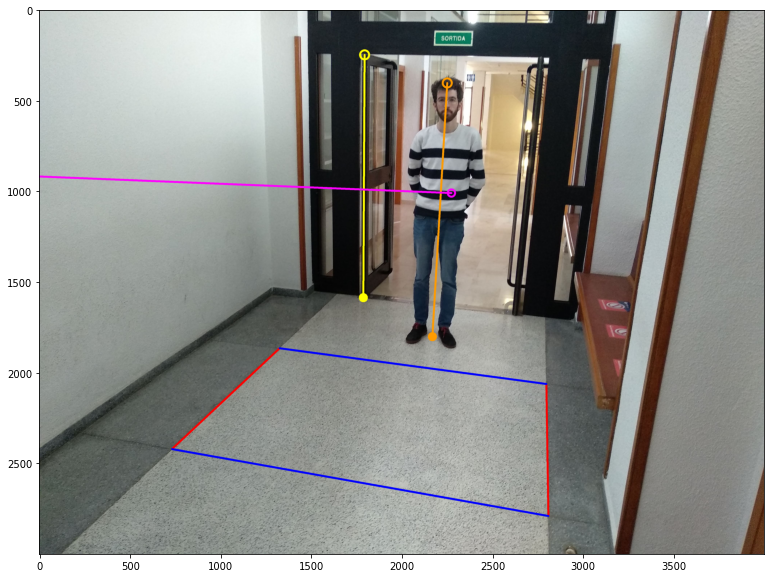

In [14]:
im = cv2.circle(im,vp1_o,20,purple,10)
im = cv2.line(im,vp1_o,vp2_o,purple,10)

plt.imshow(im)
plt.show()

## Metric factor  $\alpha$ and height

As before, we have to convert the points of the reference object and the desired object from image coordinates to homogenous coordinates to be able to use the equation shown above. As well as the vertical vanishing line, which we can get from the cross product of 2 points that belong to it.

In [15]:
b_door_h = geometry.convert(b_door_o,im,geometry.ORG_2_HMG)
t_door_h = geometry.convert(t_door_o,im,geometry.ORG_2_HMG)
b_M_h = geometry.convert(b_M_o,im,geometry.ORG_2_HMG)
t_M_h = geometry.convert(t_M_o,im,geometry.ORG_2_HMG)

In [16]:
vM_h = np.cross(b_M_h,t_M_h)
vd_h = np.cross(b_door_h,t_door_h)
vz_h = np.cross(vM_h,vd_h)
vl_h = np.cross(vp1_h,vp2_h)

From the equation presented before, we first need to calculate the value of alpha ($\alpha$). Then we can get the desired height.

In [17]:
alpha = geometry.alpha_z(b_door_h,t_door_h,vl_h,vz_h, door)
alpha

7.474583898766828e-40

In [18]:
hM = geometry.alpha_z(b_M_h,t_M_h,vl_h,vz_h,alpha)
hM

182.27168562866677

The height we have obtained for the person M is, approximately, 182.3 cm.

# Testing with other images

In order to get the height we need:
- Bottom and top points of the reference object
- Bottom and top points of the wanted height
- The corners of a parallelogram set out as we have explained before

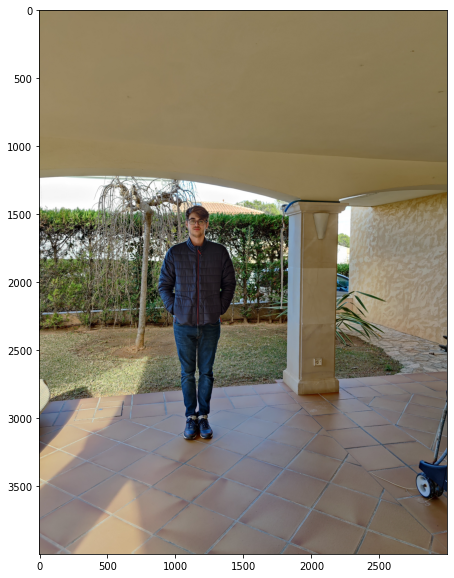

In [19]:
im2 = cv2.imread("../../in/metronomy/jardin.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
column = 203.5
plt.imshow(im2)
plt.show()

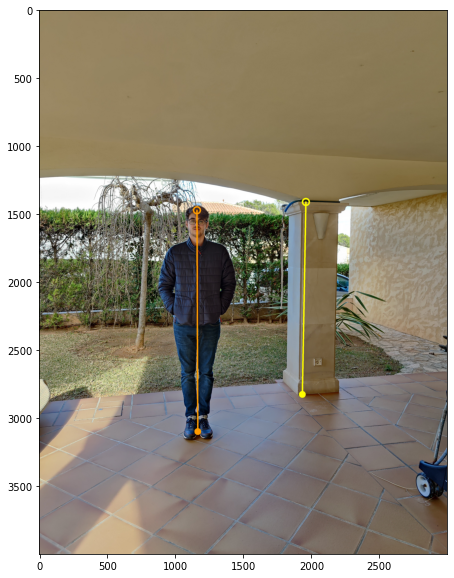

In [20]:
bcolumn, tcolumn = (1936,2826),(1962,1411) #bottom and top points of the column
bJ1, tJ1 = (1167,3099),(1161,1472) #bottom and top points of the person J

#We draw the segment representing both heights in the image
im2 = geometry.my_segment(im2,bJ1,tJ1,orange,10,25)
im2 = geometry.my_segment(im2,bcolumn,tcolumn,yellow,10,25)
plt.imshow(im2)
plt.show()

We define a function that directly returns the estimated height using the logic we have explained above.

In [21]:
a1 = (828,3505)
b1 = (1418,3090)#(1068,3335)
c1 = (1833,3915)#(1117,3616)
d1 = (2242,3318)#(1338,3428)

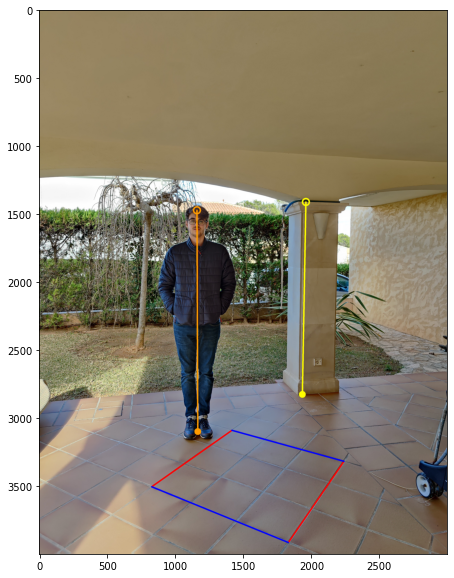

In [22]:
im2 = cv2.line(im2,a1,b1,red,10)
im2 = cv2.line(im2,c1,d1,red,10)

im2 = cv2.line(im2,a1,c1,blue,10)
im2 = cv2.line(im2,b1,d1,blue,10)

plt.imshow(im2)
plt.show()

185.7346075829192


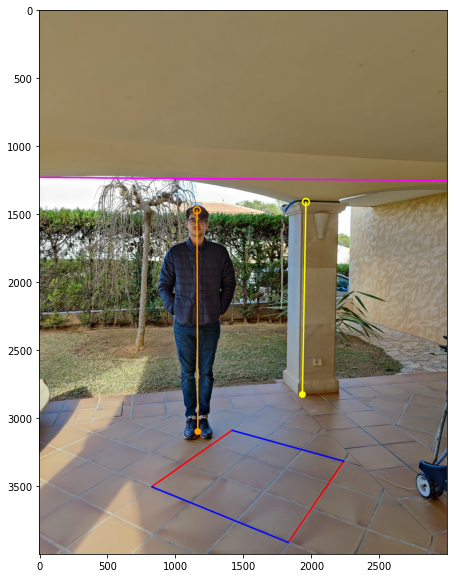

In [23]:
garden = geometry.calculateHeight(im2,203,bcolumn,tcolumn,bJ1,tJ1,a1,b1,c1,d1)
print(garden[0])
im2 = cv2.line(im2,garden[1],garden[2],purple,10)
plt.imshow(im2)
plt.show()

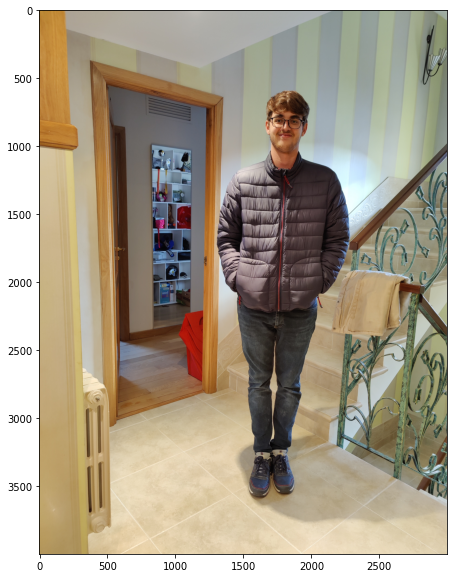

In [24]:
im3 = cv2.imread("../../in/metronomy/casa.jpg")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
door2 = 210.5
plt.imshow(im3)
plt.show()

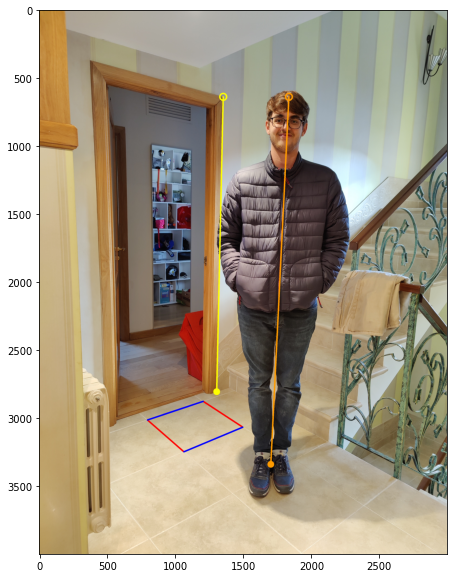

In [25]:
bpuerta, tpuerta = (1306,2806),(1354,638) #bottom and top points of the door
bJ2, tJ2 = (1704,3340),(1837,638) #bottom and top points of the person J

a2 = (1065,3248)
b2 = (797,3014)
c2 = (1498,3067)
d2 = (1207,2877)


#We draw the segment representing both heights in the image
im3 = geometry.my_segment(im3,bJ2,tJ2,orange,10,25)
im3 = geometry.my_segment(im3,bpuerta,tpuerta,yellow,10,25)


#We draw the segments representing the parallel lines on reference plane
im3 = cv2.line(im3,a2,b2,red,10)
im3 = cv2.line(im3,c2,d2,red,10)

im3 = cv2.line(im3,a2,c2,blue,10)
im3 = cv2.line(im3,b2,d2,blue,10)

plt.imshow(im3)
plt.show()

187.81789571163455


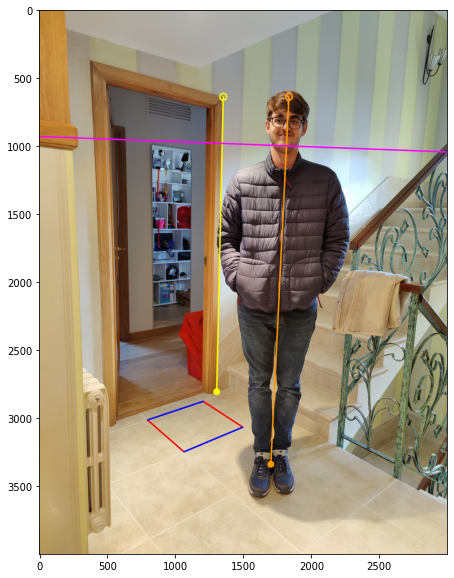

In [26]:
inhouse = geometry.calculateHeight(im3,door2,bpuerta,tpuerta,bJ2,tJ2,a2,b2,c2,d2)
print(inhouse[0])
im3 = cv2.line(im3,inhouse[1],inhouse[2],purple,10)
plt.imshow(im3)
plt.show()

According to the last two images the height estimated is 185.7 cm and 187.8 cm. The real height of J´s is aproximately 186cm, as we can see in the picture below.

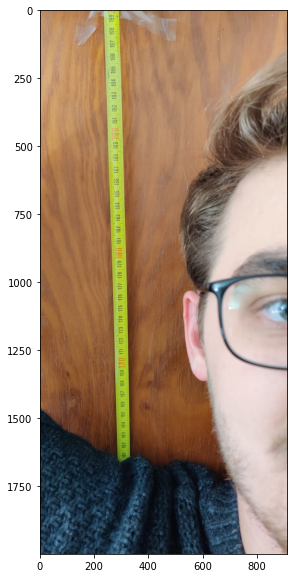

In [27]:
realHeight = cv2.imread("../../in/metronomy/realHeight.jpeg")
realHeight = cv2.cvtColor(realHeight, cv2.COLOR_BGR2RGB)
plt.imshow(realHeight)
plt.show()

### References
[1] Criminisi, A., Reid, I., & Zisserman, A. (2000). Single view metrology. International Journal of Computer Vision, 40(2), 123–148. https://doi.org/10.1023/A:1026598000963  
Code available: https://github.com/JanuszJSzturo/visio_per_computador
